In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

model_directory = ""
loaded_model = tf.saved_model.load(model_directory)
#print(list(loaded_model.signatures.keys()))  # This will show all available signatures
model = loaded_model.signatures['default']

In [2]:
def load_image(filepath: str):
    img = tf.io.decode_jpeg(tf.io.read_file(filepath))
    img = tf.image.resize(img, [514, 514], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    img = np.array(img)
    return img

def image_process(img):
    img_top = img[0:257,257:]
    img_bot = img[257:,257:]
    
    img_top_out = np.full([257,257,3], 128)
    img_top_out[:, 0:192, :] = img_top[:, 65:257, :]
    img_top_out = np.expand_dims(img_top_out.astype(np.float32)  / 255.0, axis=0)
    
    img_bot_out = np.full([257,257,3], 128)
    img_bot_out[:, 0:192, :] = img_bot[:, 65:257, :]
    img_bot_out = np.expand_dims(img_bot_out.astype(np.float32)  / 255.0, axis=0)
    
    img = np.squeeze(np.expand_dims(img.astype(np.float32)  / 255.0, axis=0))
    return img_top_out, img_bot_out, img

def predict(img):
    prediction  = model(tf.constant(img))
    output_mask = np.squeeze(prediction['masked_image'])
    output_img  = np.squeeze(prediction['default'])
    return output_mask, output_img

def expand(img):
    img_top, img_bot, img = image_process(img)
    
    output_mask_top, output_img_top = predict(img_top)
    output_mask_bot, output_img_bot = predict(img_bot)
    
    i=65
    img_final = np.full([514, 514+i, 3], -1.) # MAKE SURE THIS IS A FLOAT
    img_final[0:257, 257+i:] = np.array(output_img_top)
    img_final[257:, 257+i:] = np.array(output_img_bot)
    
    img_final[0:257, :257+i] = img[0:257, :257+i]
    img_final[257:, :257+i] = img[257:, :257+i]
    
    return img_final
    
def final(filepath: str):
    img = load_image(filepath)
    
    right = expand(img)
    left = np.fliplr(expand(np.fliplr(img)))
    mid = np.squeeze(np.expand_dims(img.astype(np.float32)  / 255.0, axis=0))
    
    i=65
    final_image = np.full([514, 514+(i*2), 3], -1.)
    final_image[:,      :i, :] = left[:, :i, :]
    final_image[:,     i:514+i, :] = mid
    final_image[:, 514+i:, :] = right[:, 514:, :]
    plt.imshow(final_image)
    plt.show()

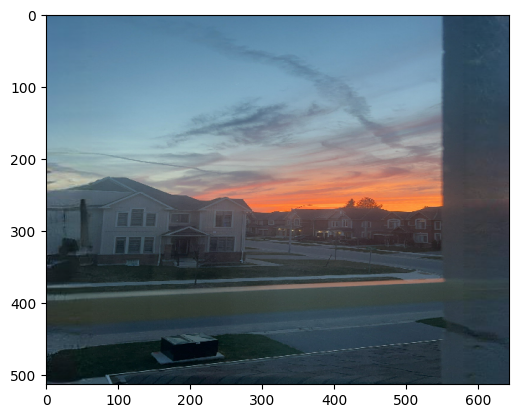

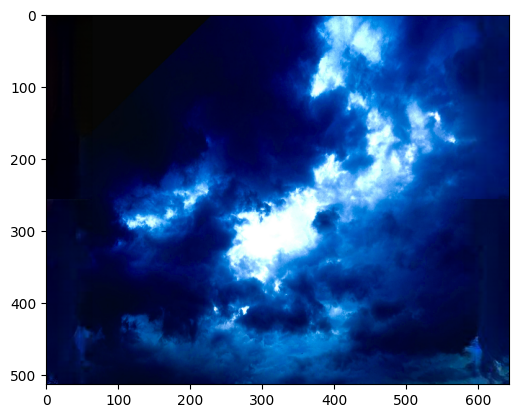

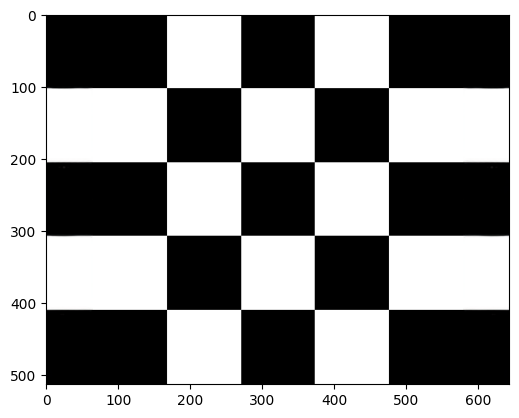

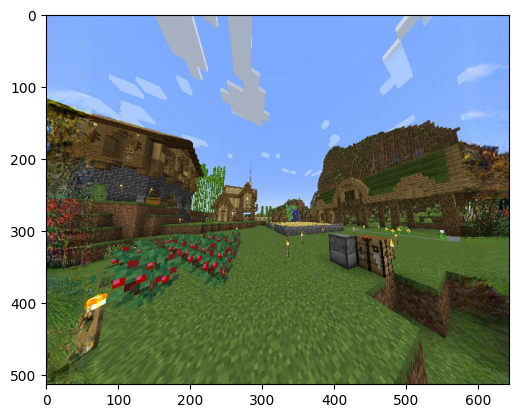

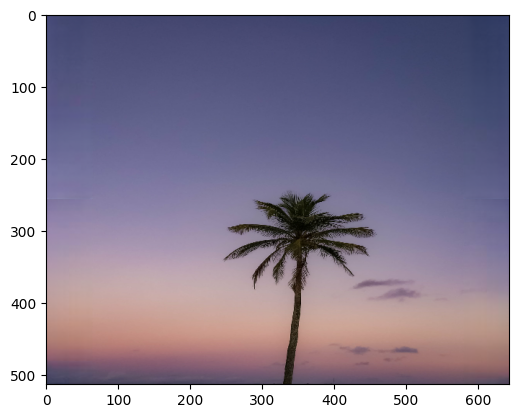

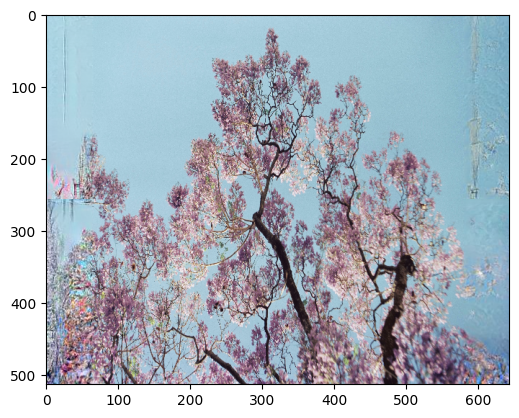

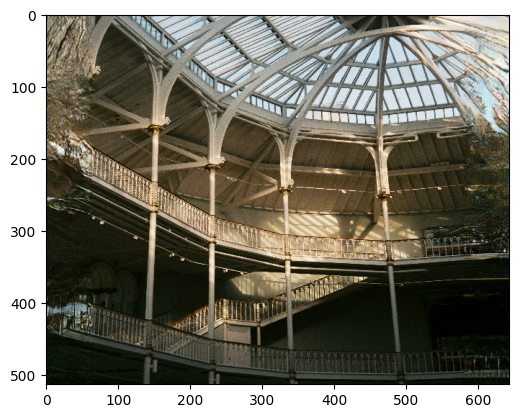

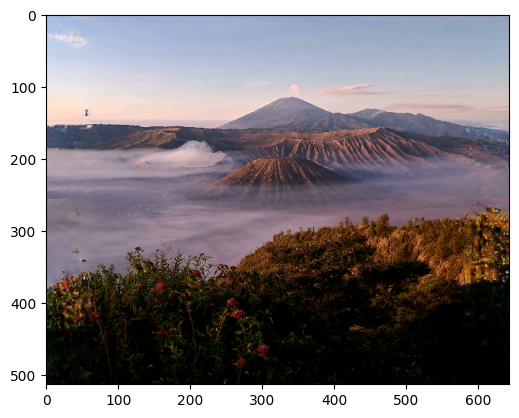

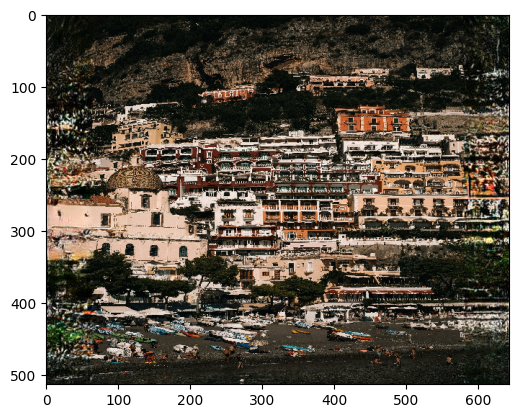

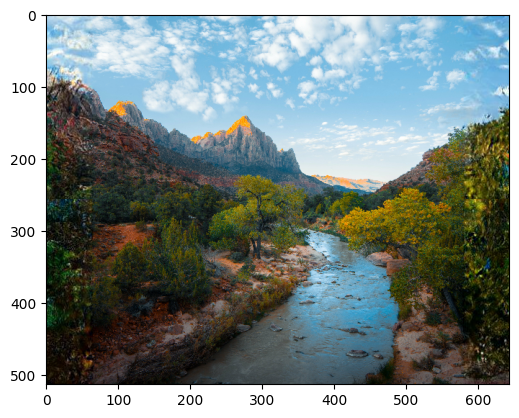

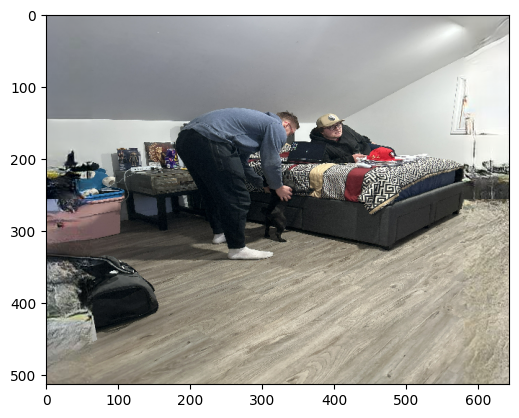

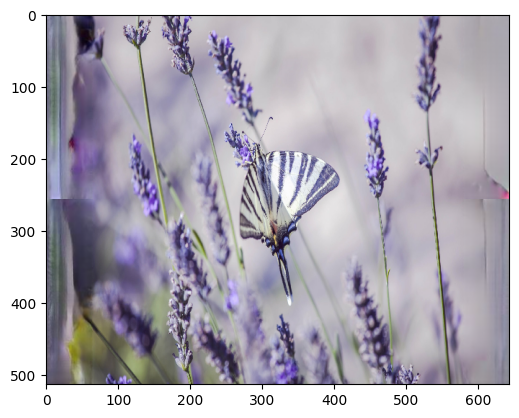

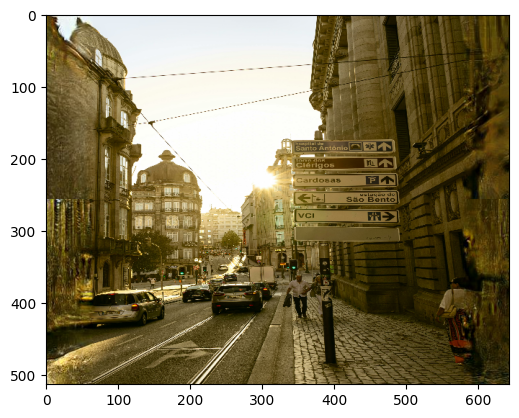

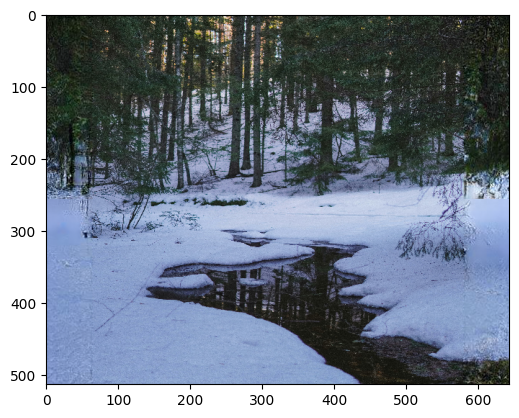

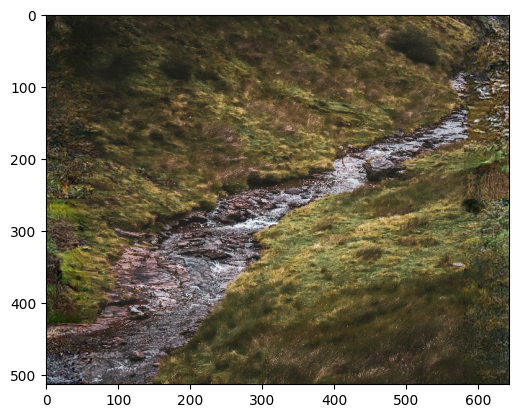

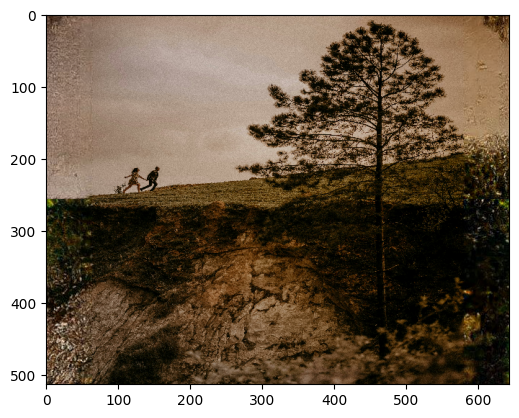

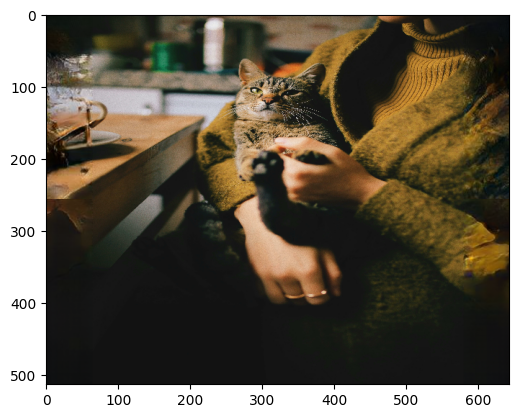

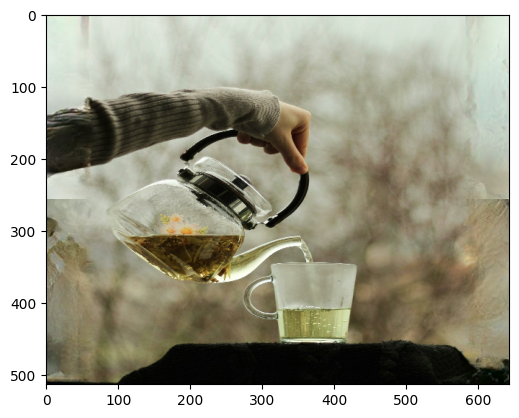

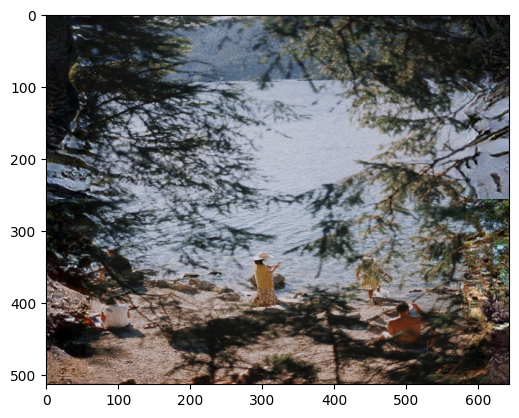

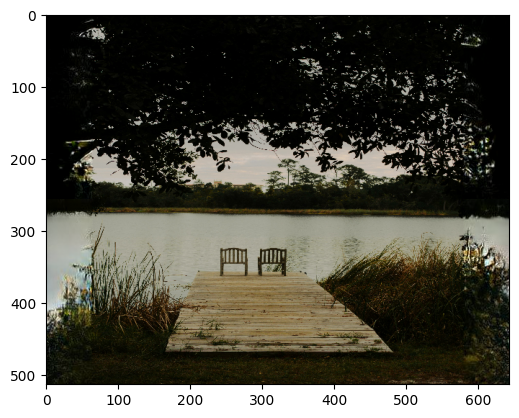

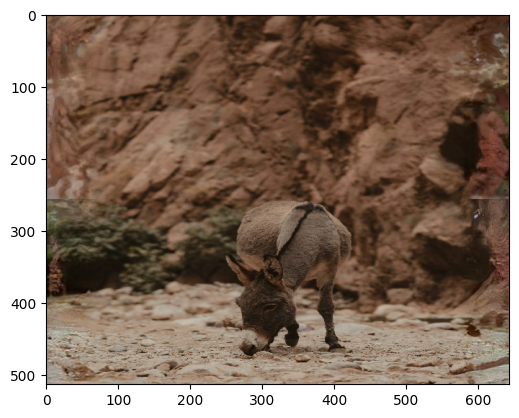

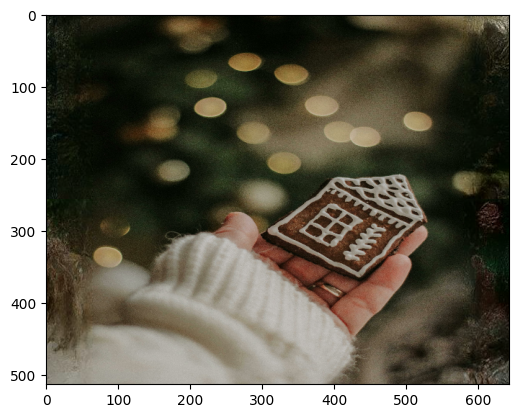

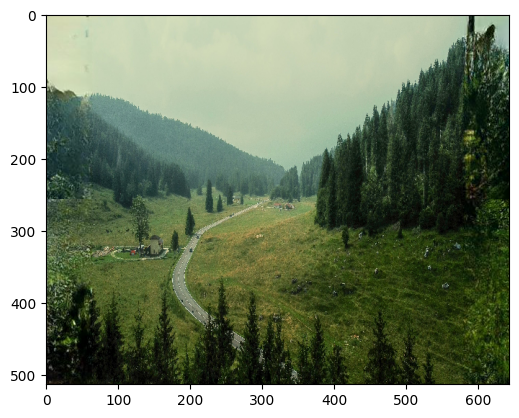

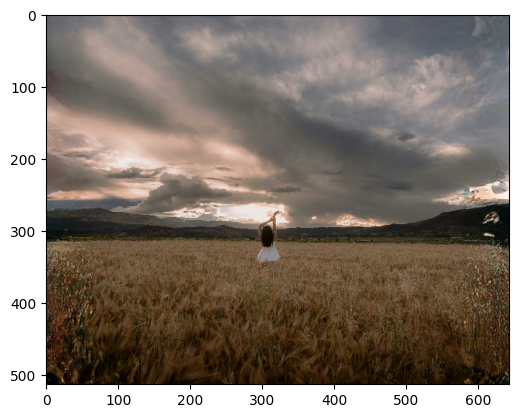

In [4]:
final('IMG_1691.jpeg')
final('IMG_1558.jpg')
final('download.jpeg')
final('mc.jpg')
for i in range(1,21,1):
    final(str(i)+'.jpg')